In [78]:
################################################################################################################################

                              ####### THIS NOTEBOOK IS FOR TESTING PURPOSES ONLY!!!!! #######
                        ####### TO TRAIN A WORKING CNN MODEL, REFER TO OTHER NOTEBOOKS!!!!! #######

################################################################################################################################

In [4]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
#from tensorflow.keras.utils import plot_model


# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio

In [2]:
def scipyio_read_file(files):
    for i, f in enumerate(files):
        if i == 0:
            im = sio.loadmat(f)
            hold_matrix = im["imgs"]
        else:
            im = sio.loadmat(f)
            imarray = im["imgs"]
            hold_matrix = np.concatenate((hold_matrix, imarray), axis = 1)
    hold_matrix = np.swapaxes(hold_matrix, 1, 3)
    hold_matrix = np.swapaxes(hold_matrix, 2, 1)
    return hold_matrix

def process_lake_images(data):
    # key = index of the lakes, value = list of image data sorted by date for that lake
    result = {} # reset dict every time function is called
    res = data.index.values
    row = None
    for it in np.unique(res):
        row = data.loc[it]
        row = row.sort_values(by=['date'])
        result[it] = np.asarray(row).reshape(1,row.shape[0], row.shape[1])
    for i in sorted(result.keys()):
        if i == 0:
            full_feat_data = result[i]
        else:
            full_feat_data = np.append(full_feat_data, result[i], axis = 0)
    
    return full_feat_data

In [16]:
# process and read image data (scipy.io/.mat)

therm_db4_files = glob.glob('/home/fun/simulation/data/thermokarst_lakes_preprocessed/wavelet-decomposed-py/wv42/*')
therm_img = scipyio_read_file(therm_db4_files)

therm_img_label = np.ones(therm_img.shape[0])
print(therm_img.shape, therm_img_label.shape)

glac_db4_files = glob.glob('/home/fun/simulation/data/glacial_lakes_preprocessed/wavelet-decomposed-py/wv42/*')
glac_img = scipyio_read_file(glac_db4_files)

glac_img_label = np.zeros(glac_img.shape[0])
print(glac_img.shape, glac_img_label.shape)

(252, 36, 36, 144) (252,)
(251, 36, 36, 144) (251,)


In [17]:
# process and read time-series data (pandas/.pkl)

therm_feat_data = pd.read_pickle("/home/fun/simulation/data/thermokarst_lakes_preprocessed/non-image data.pkl")
glac_feat_data = pd.read_pickle("/home/fun/simulation/data/glacial_lakes_preprocessed/non-image data.pkl")
'''
therm_feat_data['date'] = therm_feat_data['date'].astype('int')
therm_feat_data['date'] = pd.to_datetime(therm_feat_data['date'], format='%Y%m%d')  

therm_feat_sort = therm_feat.sort_index()

glac_feat_data['date'] = glac_feat_data['date'].astype('int')
glac_feat_data['date'] = pd.to_datetime(glac_feat_data['date'], format='%Y%m%d')  

glac_feat_sort = glac_feat.sort_index()

therm_feat_data = process_lake_images(therm_feat_sort)
glac_feat_data = process_lake_images(glac_feat_sort)

therm_feat_data = np.delete(therm_feat_data, [0, 1, 2, 3], axis = 2)
glac_feat_data = np.delete(glac_feat_data, [0, 1, 2, 3], axis = 2)
'''
therm_feat_label = np.ones(therm_feat_data.shape[0])
print(therm_feat_data.shape, therm_feat_label.shape)

glac_feat_label = np.zeros(glac_feat_data.shape[0])
print(glac_feat_data.shape, glac_feat_label.shape)

(252, 17) (252,)
(251, 17) (251,)


In [18]:
# img
non_shuf_spatial_data = np.append(therm_img, glac_img, axis = 0)
non_shuf_spatial_data = non_shuf_spatial_data.astype("float32")

non_shuf_spatial_label = np.append(therm_img_label, glac_img_label, axis = 0)

non_shuf_spatial_label = non_shuf_spatial_label.reshape(non_shuf_spatial_label.shape[0], 1)
print(non_shuf_spatial_data.shape)

# time
non_shuf_feat_data = np.append(therm_feat_data, glac_feat_data, axis = 0)
non_shuf_feat_data = non_shuf_feat_data.astype("float32")

non_shuf_feat_label = np.append(therm_feat_label, glac_feat_label, axis = 0)

non_shuf_feat_label = non_shuf_feat_label.reshape(non_shuf_feat_label.shape[0], 1)
print(non_shuf_feat_data.shape)

(503, 36, 36, 144)
(503, 17)


In [19]:
for i in range(non_shuf_spatial_data.shape[0]):
    for j in range(non_shuf_spatial_data.shape[3]):
        scaler = StandardScaler()
        scaler.fit(non_shuf_spatial_data[i, :, :, j])
        non_shuf_spatial_data[i, :, :, j] = scaler.transform(non_shuf_spatial_data[i, :, :, j])

In [20]:
# normalize data

scaler = StandardScaler()

scaler.fit(non_shuf_feat_data)

non_shuf_feat_scaler = scaler.transform(non_shuf_feat_data) # see scikit-learn documentation for details

type(non_shuf_feat_scaler)

numpy.ndarray

In [21]:
# img
X_train_spatial, X_test_spatial, y_train_spatial, y_test_spatial = train_test_split(
    non_shuf_spatial_data, non_shuf_spatial_label, train_size = 0.7, random_state = 3928983)

train_spatial_ones = np.sum(y_train_spatial)
test_spatial_ones = np.sum(y_test_spatial)

print(y_train_spatial.shape, y_test_spatial.shape)
print(train_spatial_ones, test_spatial_ones)

# time
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    non_shuf_feat_scaler, non_shuf_feat_label, train_size = 0.7, random_state = 3928983)

train_feat_ones = np.sum(y_train_feat)
test_feat_ones = np.sum(y_test_feat)

print(y_train_feat.shape, y_test_feat.shape)
print(train_feat_ones, test_feat_ones)

(352, 1) (151, 1)
177.0 75.0
(352, 1) (151, 1)
177.0 75.0


In [5]:
# feature extraction from spatial data
spatial_inputs = Input(shape = (36, 36, 144))

spatial_conv1 = Conv2D(filters = 9, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same")(spatial_inputs)

spatial_pool1 = AveragePooling2D(pool_size = (3,3), 
                         strides = 3)(spatial_conv1)

spatial_batch1 = BatchNormalization()(spatial_pool1)

spatial_conv2 = Conv2D(filters = 9, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same")(spatial_batch1)

spatial_pool2 = AveragePooling2D(pool_size = (3,3), 
                         strides = 3)(spatial_conv2)

spatial_batch2 = BatchNormalization()(spatial_pool2)

spatial_flat = Flatten()(spatial_batch2)

# feature extraction from non-img feature data
feat_inputs = Input(shape = (17))

# concatenate both feature layers and define output layer after some dense layers

concat = concatenate([spatial_flat, feat_inputs])

dense1 = Dense(128, activation = 'relu')(concat)
dense1dropout = Dropout(0.5)(dense1)

dense2 = Dense(32, activation = 'relu')(dense1dropout)
dense2dropout = Dropout(0.5)(dense2)

output = Dense(1, activation = 'sigmoid')(dense2dropout)

# create model with two inputs
model = Model([spatial_inputs, feat_inputs], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36, 36, 144) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 36, 36, 9)    104985      input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 12, 12, 9)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12, 12, 9)    36          average_pooling2d[0][0]          
______________________________________________________________________________________________

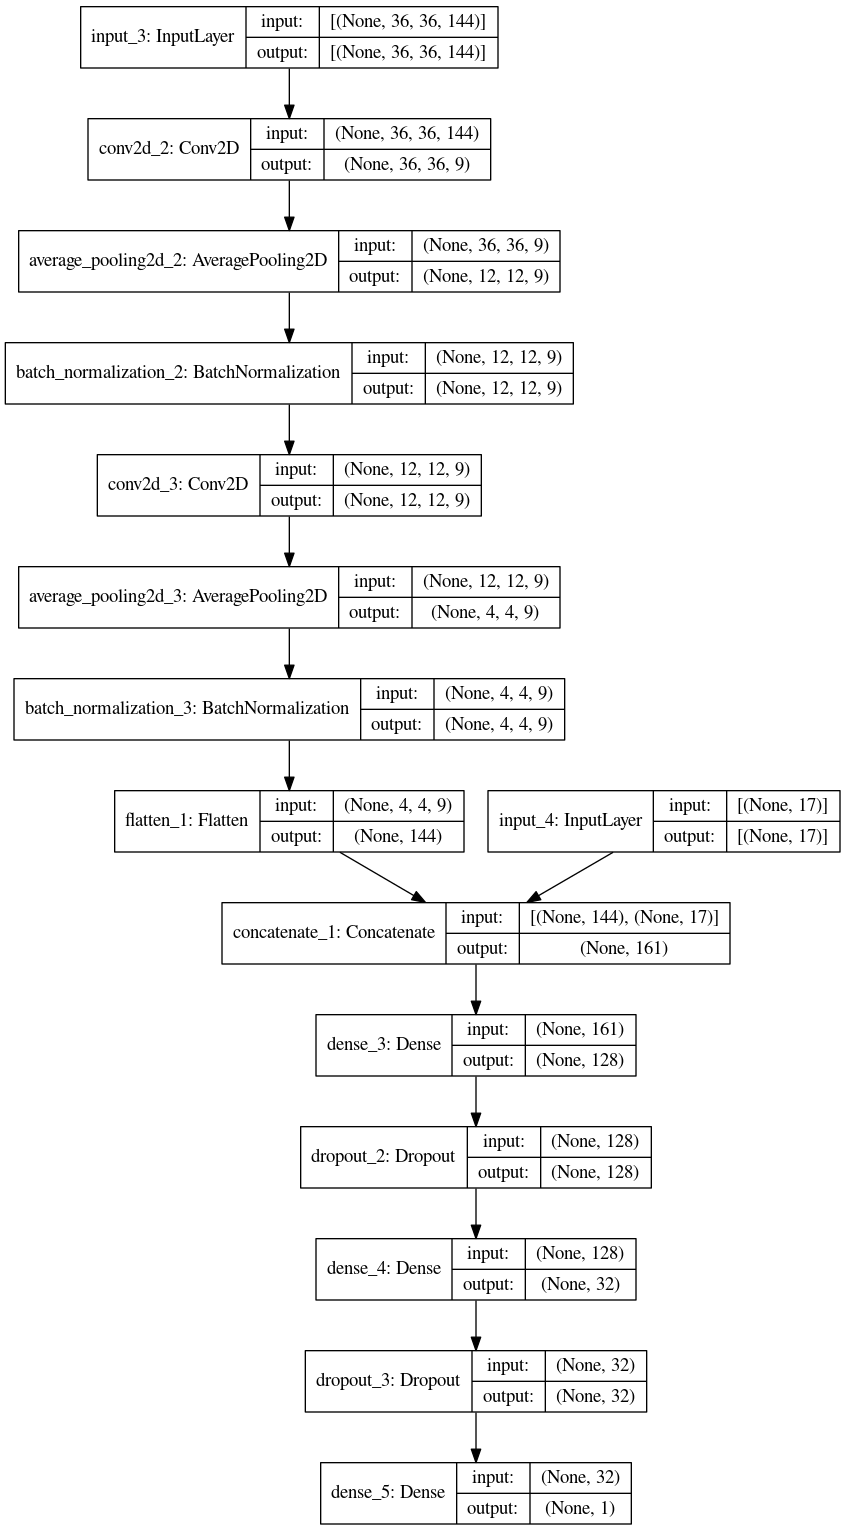

In [23]:
tf.keras.utils.plot_model(model, to_file='dense_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
model.compile(
    loss = keras.losses.BinaryCrossentropy(), 
    optimizer = "adam",
    metrics = ['acc']
)

Epoch 1/20
71/71 [==============================] - 17s 229ms/step - loss: 0.8151 - acc: 0.5625 - val_loss: 0.6426 - val_acc: 0.5894
Epoch 2/20
71/71 [==============================] - 16s 224ms/step - loss: 0.6667 - acc: 0.5966 - val_loss: 0.6045 - val_acc: 0.6755
Epoch 3/20
71/71 [==============================] - 16s 223ms/step - loss: 0.6156 - acc: 0.6534 - val_loss: 0.5323 - val_acc: 0.7285
Epoch 4/20
71/71 [==============================] - 16s 221ms/step - loss: 0.4993 - acc: 0.7670 - val_loss: 0.4312 - val_acc: 0.8278
Epoch 5/20
71/71 [==============================] - 16s 223ms/step - loss: 0.4861 - acc: 0.7841 - val_loss: 0.5425 - val_acc: 0.7483
Epoch 6/20
71/71 [==============================] - 16s 223ms/step - loss: 0.3991 - acc: 0.8125 - val_loss: 0.4359 - val_acc: 0.8212
Epoch 7/20
71/71 [==============================] - 16s 223ms/step - loss: 0.2874 - acc: 0.8864 - val_loss: 0.4911 - val_acc: 0.8079
Epoch 8/20
71/71 [==============================] - 16s 223ms/step - 

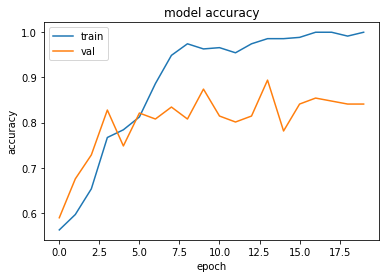

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='wv42model.{epoch:02d}-{val_loss:.2f}.h5',
        save_best_only = False
    ),
]

history = model.fit([X_train_spatial, X_train_feat], y_train_spatial, 
          batch_size = 5, 
          epochs = 20, 
          validation_data = ([X_test_spatial, X_test_feat], y_test_spatial), 
          callbacks = callbacks
          )

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

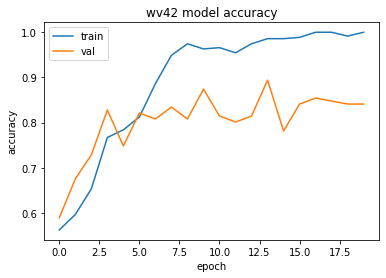

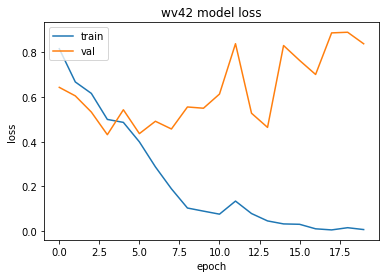

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('wv42 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('wv42 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

In [6]:
conv1_weights = model.layers[1].get_weights()[0]

conv1_weights_abs = np.absolute(conv1_weights)

list_avgs = []

for i in range(conv1_weights.shape[2]):

    hold_weights = conv1_weights_abs[:, :, i, :]
    hold_sum = hold_weights.sum()
    hold_avg = hold_sum / 729
    list_avgs.append(hold_avg)
    
list_avgs

[0.011164051678609128,
 0.011084591900860821,
 0.010960828129646709,
 0.01089244418674045,
 0.010406331270319934,
 0.011036432001979917,
 0.011036766899956597,
 0.011039048392422732,
 0.011374362375183524,
 0.01118948691829896,
 0.01069765653466328,
 0.010831117302956078,
 0.011185661755471563,
 0.011165370339392307,
 0.011119808516221118,
 0.011368969994480881,
 0.011347424019184295,
 0.010742999889232495,
 0.010839186905179331,
 0.011319091127079047,
 0.010878827182680817,
 0.010717075384529857,
 0.011071768971300583,
 0.010968674030487102,
 0.010947077035576881,
 0.011155854527351787,
 0.011073338805566272,
 0.01112151963557072,
 0.010983366371018733,
 0.011049134577579786,
 0.011239694142701368,
 0.011190523008914315,
 0.01062496797538098,
 0.010838404604436929,
 0.01125475146969977,
 0.010396351048975815,
 0.010875077895176263,
 0.010814664131656432,
 0.01100458791390041,
 0.010934339138706034,
 0.011236779483748072,
 0.010962206313312463,
 0.011086949268649799,
 0.011063624147852

In [70]:
list_avgs_sort = sorted(enumerate(list_avgs), key = lambda x: x[1])

list_avgs_sort

[(8, 0.012398821826824925),
 (1, 0.01321332117821127),
 (0, 0.013612129724238309),
 (2, 0.014373614464277103),
 (3, 0.01502382019419729),
 (5, 0.015465269363466113),
 (4, 0.015606477263860087),
 (7, 0.01616925238254793),
 (6, 0.01617244830347383),
 (10, 0.017187160392520523),
 (9, 0.017216333145957916),
 (36, 0.01760433076667524),
 (17, 0.01765285696021814),
 (32, 0.01766622933177137),
 (12, 0.017883740334844394),
 (30, 0.018115822016293456),
 (31, 0.018275063387814535),
 (27, 0.01847057839643481),
 (40, 0.01874487292128826),
 (44, 0.018813126698769986),
 (35, 0.018834090527193047),
 (28, 0.01889277878121584),
 (13, 0.018979916356718588),
 (14, 0.018985644943593134),
 (11, 0.019091269933964816),
 (39, 0.01936148812250836),
 (37, 0.019454427543818053),
 (29, 0.01966071684828184),
 (111, 0.019780709746770243),
 (38, 0.019850860407323014),
 (18, 0.020317404685524103),
 (76, 0.020412947415324397),
 (26, 0.020443122246301387),
 (54, 0.02051339587720497),
 (50, 0.02064899816107521),
 (65, 0.

In [7]:
filename = 'wv42_model_weights'

model.save_weights(filename.format(epoch = 14))

y_pred = model.predict([X_test_spatial, X_test_feat], )
y_pred_round = np.rint(y_pred)

y_pred_round = y_pred_round.reshape(y_pred_round.shape[0])

print(y_pred_round)

NameError: name 'X_test_spatial' is not defined

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision: ", precision_score(y_test_spatial, y_pred_round))
print("recall: ", recall_score(y_test_spatial, y_pred_round))
print("f1 score: ", f1_score(y_test_spatial, y_pred_round))

precision:  0.9402985074626866
recall:  0.84
f1 score:  0.8873239436619718


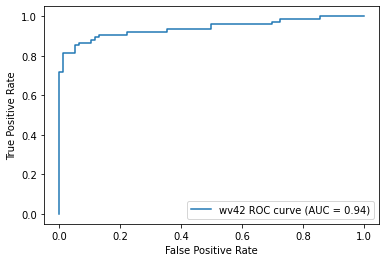

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_spatial, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='wv42 ROC curve')
display.plot()

plt.show()

In [30]:
def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("wv42 confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

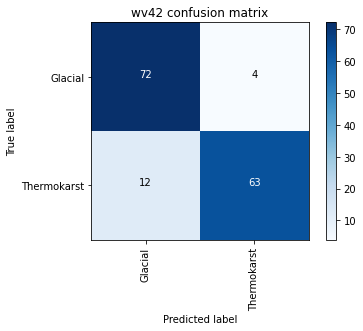

In [31]:
draw_confusion_matrix(y_test_spatial, y_pred_round, ['Glacial', 'Thermokarst'])
fig = plt.ylabel('True label')
fig = plt.xlabel('Predicted label')
fig = plt.show()

In [100]:
#for i in range(0, 9):
#    X_test_spatial_shuf = 

X_random = X_test_spatial

X_test_spatial_approx = X_test_spatial[:, :, :, 0:9]

X_test_spatial_approx = X_test_spatial_approx.reshape(1761264)

np.random.shuffle(X_test_spatial_approx)

X_test_spatial_shuf = X_test_spatial_approx.reshape(151, 36, 36, 9)

X_random[:, :, :, 0:9] = X_test_spatial_shuf

In [101]:
y_pred = model.predict([X_random, X_test_feat], )
y_pred_round = np.rint(y_pred)

y_pred_round = y_pred_round.reshape(y_pred_round.shape[0])

print(y_pred_round)

[1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1.]


In [102]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision: ", precision_score(y_test_spatial, y_pred_round))
print("recall: ", recall_score(y_test_spatial, y_pred_round))
print("f1 score: ", f1_score(y_test_spatial, y_pred_round))

precision:  0.8732394366197183
recall:  0.8266666666666667
f1 score:  0.8493150684931506


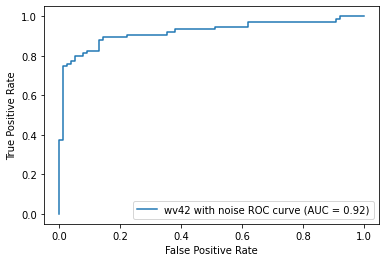

In [105]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_spatial, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='wv42 with noise ROC curve')
display.plot()

plt.show()

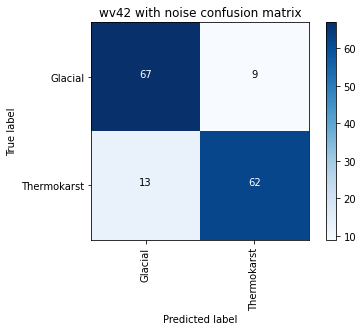

In [106]:
def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("wv42 with noise confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

draw_confusion_matrix(y_test_spatial, y_pred_round, ['Glacial', 'Thermokarst'])
fig = plt.ylabel('True label')
fig = plt.xlabel('Predicted label')
fig = plt.show()

In [69]:
dense1_weights = model.layers[10].get_weights()[0]

print(dense1_weights, len(dense1_weights))

last_17 = abs(dense1_weights[-17:])

feature_weight = []

for i in range(len(last_17)):

    hold_weights = last_17[i, :]
    hold_sum = hold_weights.sum()
    hold_avg = hold_sum / 128
    feature_weight.append(hold_avg)
    
feature_weight_sort = sorted(enumerate(feature_weight), key = lambda x: x[1], reverse = True)

feature_weight_sort

[[-0.1273396   0.07012251 -0.12956372 ...  0.08088556 -0.06657421
   0.14043139]
 [-0.08939543 -0.06321409 -0.03873656 ... -0.1427931  -0.03523848
   0.06656288]
 [ 0.00219476  0.1111448   0.01054446 ...  0.1299481   0.07791828
  -0.10399927]
 ...
 [-0.0381113   0.05041389 -0.00331391 ...  0.02168828  0.03949481
  -0.09638578]
 [-0.0563642   0.0402343  -0.03405955 ... -0.02447303  0.01996617
   0.09234674]
 [ 0.090397   -0.07663652  0.01945399 ... -0.13113566  0.07702585
  -0.13278471]] 161


[(3, 0.0795249193906784),
 (14, 0.07820068299770355),
 (13, 0.07737189531326294),
 (6, 0.07539163529872894),
 (8, 0.07528669387102127),
 (10, 0.07455205172300339),
 (9, 0.07236652076244354),
 (5, 0.07186135649681091),
 (15, 0.07070493698120117),
 (2, 0.07013995200395584),
 (11, 0.06977716833353043),
 (4, 0.06963646411895752),
 (0, 0.06919176131486893),
 (16, 0.0687849149107933),
 (1, 0.06864010542631149),
 (12, 0.06780591607093811),
 (7, 0.06549623608589172)]

In [70]:
names = \
['2 metre temperature',
 'Evaporation',
 'Evaporation from bare soil',
 'Lake bottom temperature',
 'Lake ice surface temperature',
 'Lake ice total depth',
 'Lake shape factor',
 'Leaf area index, high vegetation',
 'Leaf area index, low vegetation',
 'Snow albedo',
 'Snow cover',
 'Snow depth',
 'Snow evaporation',
 'Snowmelt',
 'Soil temperature level 1',
#'Surface pressure',
 'Surface runoff',
#'Surface solar radiation downwards',
 'Total precipitation']

In [71]:
feature_weight_sort = np.asarray(feature_weight_sort)
list_best = feature_weight_sort[:, 0]
list_best = list_best.astype('int')

for i in list_best:
    print(names[i])

Lake bottom temperature
Soil temperature level 1
Snowmelt
Lake shape factor
Leaf area index, low vegetation
Snow cover
Snow albedo
Lake ice total depth
Surface runoff
Evaporation from bare soil
Snow depth
Lake ice surface temperature
2 metre temperature
Total precipitation
Evaporation
Snow evaporation
Leaf area index, high vegetation
